# Methods: Environmental Pathogen Transmission Model


## Model Structure
We developed a deterministic compartmental model to simulate the transmission of a persistent environmental pathogen in a system consisting of livestock hosts, an environmental reservoir, and scavengers. The model tracks four state variables: Susceptible Hosts ($S$), Infected Hosts ($I$), Infectious Carcasses ($C$), and Environmental Pathogen Reservoir ($E$). This framework builds upon established epidemiological models where host mortality generates infectious patches in the environment, as seen in models of anthrax transmission [1](https://doi.org/10.1007/s11538-016-0238-1).


## Host and Pathogen Dynamics
Host population dynamics follow a logistic growth function with carrying capacity $K_{cap}$ and natural mortality $\mu$. Susceptible individuals ($S$) contract the pathogen through contact with the environmental reservoir ($E$) at a transmission rate $\beta$. Infected individuals ($I$) succumb to the disease at rate $\alpha$ (the sum of disease-induced and natural mortality), transitioning into the Carcass state ($C$). The disease-induced mortality rate was parameterized to correspond to an average infectious period of approximately 7 days [1](https://doi.org/10.1007/s11538-016-0238-1).


## The Scavenger Filter Mechanism
The core of this model investigates the role of scavengers in altering the reproductive number $R_0$ by removing infectious biomass before it can contaminate the environment. Carcasses ($C$) have two competing fates:

1. **Reservoir Formation:** Carcasses decay naturally at rate $\kappa$, releasing a burst of pathogen load $\phi$ into the environment to form a localized infectious zone (LIZ). The decay rate $\kappa$ was set to $0.1$ day$^{-1}$, representing an average decay period of 10 days in the absence of scavenging [1](https://doi.org/10.1007/s11538-016-0238-1).
2. **Scavenging:** Scavengers consume carcasses at rate $\sigma$. We assume scavenged carcasses are effectively removed from the transmission cycle without contributing to the environmental reservoir.


## Reproductive Number and Scavenger Control
The reproductive number component for hosts ($K_{LL}$) is proportional to the probability that a carcass remains in the environment to form a LIZ. In our ODE, this probability is governed by the competition between natural decay ($\kappa$) and scavenging ($\sigma$):

$$
(1 - \gamma_L) = \frac{\kappa}{\kappa + \sigma}
$$

Where $\gamma_L$ represents the "scavenging capacity" or the proportion of carcasses removed:
- **Low Scavenging ($\sigma = 0$):** $(1 - \gamma_L) = 1$. All infected carcasses degrade naturally and contaminate the environment.
- **High Scavenging ($\sigma \gg \kappa$):** $(1 - \gamma_L) \to 0$. Most carcasses are removed before they can establish an environmental reservoir, effectively driving $R_0 < 1$.


## Parameterization
Parameters were derived from literature on environmental pathogen persistence and host dynamics:
- **Carcass decay ($\kappa$):** Set to $0.1$ day$^{-1}$ (approx. 10 days) [1](https://doi.org/10.1007/s11538-016-0238-1).
- **Disease mortality ($\alpha$):** Set to $0.14$ day$^{-1}$ (approx. 7 days) [1](https://doi.org/10.1007/s11538-016-0238-1).
- **Host Lifespan ($\mu$):** Set to correspond to an average lifespan of 5 years ($1/\mu \approx 2000$ days), consistent with livestock demographics in similar systems [2](https://doi.org/10.1038/s41598-020-72440-6).
- **Pathogen persistence ($\delta$):** Assumed to be long-term with a low decay rate, as spores or infectious agents can persist in the environment for years to decades [2](https://doi.org/10.1038/s41598-020-72440-6) [3](https://doi.org/10.1098/rspb.2023.2568).


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, PIDController

In [33]:
# --- 1. Seasonal Model Definition ---
def seasonal_liz_model(t, y, args):
    """
    Seasonal LIZ Model with Constant Grazing Pressure.
    y = [I, C, E] (S is constant parameter)
    """
    I, C, E = y
    beta_0, epsilon, S_const, alpha, kappa, sigma, phi, delta = args

    # Explicit Seasonality (Sinusoidal Forcing) - Stella et al. (2020) Eq. 8
    # 2*pi*t/365 implies t is in days.
    # Phase shift can be added if needed, here we assume peak at t ~ 90 (Spring/Summer)
    beta_t = beta_0 * (1 + epsilon * jnp.sin(2 * jnp.pi * t / 365.0))
    
    # 1. New Infections (Generated by the LIZ)
    # S is constant (grazing pressure), not depleted.
    new_infections = beta_t * S_const * E 
    
    # 2. Infection Dynamics
    dI = new_infections - alpha * I
    
    # 3. Carcass Dynamics (The Scavenger Filter)
    dC = alpha * I - (kappa + sigma) * C
    
    # 4. Environmental Reservoir Dynamics
    # Inflow: Only naturally decaying carcasses (kappa * C)
    # Outflow: Environmental decay (delta * E)
    dE = phi * kappa * C - delta * E

    return jnp.array([dI, dC, dE])

In [41]:
# --- 2. Simulation Setup ---
def run_seasonal_simulation(sigma_val, label):
    # Parameters
    params = (
        1.5e-7,  # beta_0: Baseline transmission (calibrated for endemicity)
        1.0,     # epsilon: Amplitude of seasonality (0 to 1)
        1000.0,  # S_const: Constant grazing herd size
        0.14,    # alpha: Infectious period (~7 days)
        0.1,     # kappa: Carcass decay (~10 days)
        sigma_val, # sigma: Scavenging rate
        100.0,   # phi: Spores per carcass
        0.0005   # delta: Long-term spore decay (~5.5 years)
    )

    # Initial Conditions
    # Start with a small seed of spores in the environment, no active infections
    y0 = jnp.array([1.0, 0.0, 1.0]) 
    
    t0, t1 = 0.0, 365
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 2000))
    
    sol = diffeqsolve(
        ODETerm(seasonal_liz_model), Tsit5(), t0, t1, dt0=0.1, y0=y0, args=params,
        saveat=saveat, stepsize_controller=PIDController(rtol=1e-5, atol=1e-5)
    )
    return sol

In [42]:
# --- 3. Run Comparisons ---

# Scenario A: No Scavengers (sigma = 0)
sol_no_scav = run_seasonal_simulation(0.0, "No Scavengers")

# Scenario B: High Scavenging (sigma = 0.9)
sol_high_scav = run_seasonal_simulation(0.9, "High Scavenging")

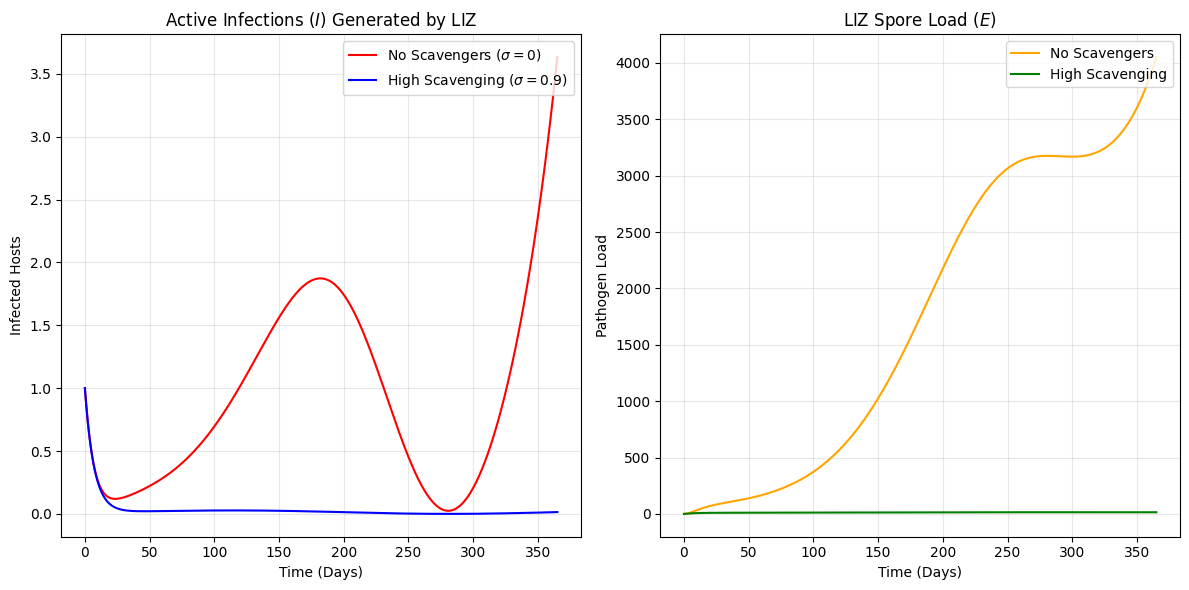

In [43]:
# --- 4. Visualization ---
plt.figure(figsize=(12, 6))

# Plot 1: Seasonal Infection Rate (New Cases)
# We plot I(t) which proxies active prevalence generated by the zone
plt.subplot(1, 2, 1)
plt.plot(sol_no_scav.ts, sol_no_scav.ys[:, 0], label='No Scavengers ($\sigma=0$)', color='red', linewidth=1.5)
plt.plot(sol_high_scav.ts, sol_high_scav.ys[:, 0], label='High Scavenging ($\sigma=0.9$)', color='blue', linewidth=1.5)
plt.title('Active Infections ($I$) Generated by LIZ')
plt.xlabel('Time (Days)')
plt.ylabel('Infected Hosts')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Plot 2: Environmental Spore Load
plt.subplot(1, 2, 2)
plt.plot(sol_no_scav.ts, sol_no_scav.ys[:, 2], label='No Scavengers', color='orange', linewidth=1.5)
plt.plot(sol_high_scav.ts, sol_high_scav.ys[:, 2], label='High Scavenging', color='green', linewidth=1.5)
plt.title('LIZ Spore Load ($E$)')
plt.xlabel('Time (Days)')
plt.ylabel('Pathogen Load')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()